In [240]:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [588]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import string
import pickle
%matplotlib inline

# LSA, NMF
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

# spacy for lemmatization
import spacy

# to track time
from time import time

In [318]:
print(spacy.__version__)

2.0.18


# Pre-processing functions

In [433]:
nlp = spacy.load('en')

In [434]:
#parser = English()
STOPLIST = set(list(ENGLISH_STOP_WORDS))
SYMBOLS=" ".join(string.punctuation).split(" ") + ["-", "...", "”", "'"]
ENTITIES=[]

In [435]:
def tokenizeText(text):
    tokens = nlp(text)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    tokens = [tok for tok in tokens if len(tok)>2]
    return tokens

In [436]:
def cleanText(text):
    # remove entities that are not important to topic modeling
    for ent in ENTITIES:
        text=text.replace(ent, "")
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()

    return text

In [437]:
def evaluate_plot(plot):
    doc = nlp(plot)
    ent_arr={}

    for ent in doc.ents:
        if (ent.label_ in ['ORG','GPE','PERSON']):
            ent_arr[str(ent)]=str(ent.label_)
        elif (ent.label_=='EVENT'):
            ent_arr[str(ent)]=str(ent.label_)
    return ent_arr

# Pre-process data for topic modeling

In [438]:
df=pd.read_pickle('../data/interim/cleaned_data.pkl')

## Sample to smaller data set

In [444]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26880 entries, 6 to 34885
Data columns (total 11 columns):
Release Year        26880 non-null int64
Title               26880 non-null object
Origin/Ethnicity    26880 non-null object
Director            26880 non-null object
Cast                26248 non-null object
Genre               26880 non-null object
Wiki Page           26880 non-null object
Plot                26880 non-null object
Genre_c             26880 non-null object
sentiment           26880 non-null object
genre_weights       26880 non-null float64
dtypes: float64(1), int64(1), object(9)
memory usage: 2.5+ MB


In [586]:
# check for class imbalance
class_im=df.groupby('Genre_c')['Title'].count()

Text(0.5, 1.0, 'Movies Count by Genre')

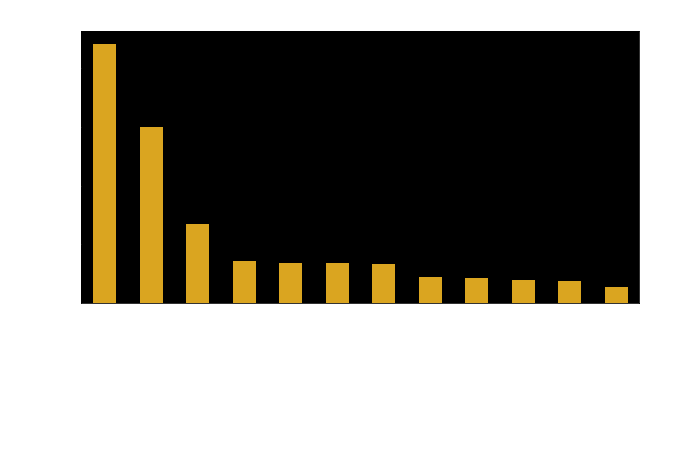

In [632]:
ax=class_im.sort_values(ascending=False).plot(kind='bar', title='Genre Count', rot=45, 
                                           figsize=(10,5), fontsize=18, color='goldenrod')
ax.set_facecolor('black')
ax.set_xlabel("Genre", color="white", fontsize=18)
ax.tick_params(axis='x', colors='white')
ax.set_ylabel("Count", color="white", fontsize=18)
ax.tick_params(axis='y', colors='white')
ax.set_title('Movies Count by Genre', color='white', fontsize=24)

In [440]:
# form weights to sample for balance
weights=1/(df.groupby('Genre_c')['Title'].count()/df['Title'].count())
weights=weights/sum(weights)
df['genre_weights']= df['Genre_c'].apply(lambda x: weights[x])

In [449]:
# sample with weights
df2=df.sample(10000, weights='genre_weights')

In [633]:
# check for balance again
class_im2=df2.groupby('Genre_c')['Title'].count()

Text(0.5, 1.0, 'Movies Count by Genre')

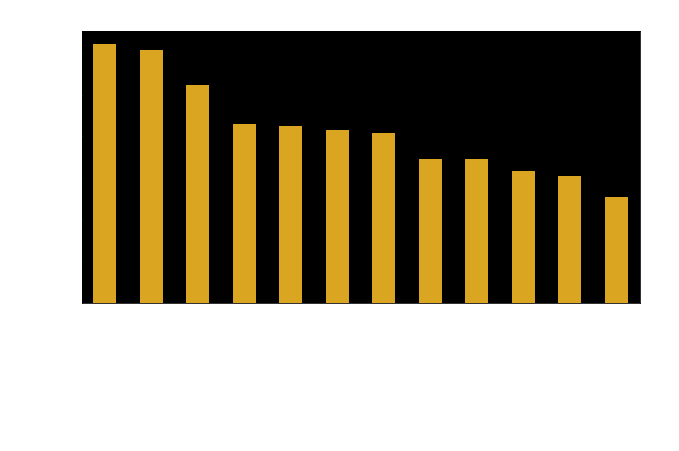

In [634]:
ax=class_im2.sort_values(ascending=False).plot(kind='bar', title='Genre Count', rot=45, 
                                           figsize=(10,5), fontsize=18, color='goldenrod')
ax.set_facecolor('black')
ax.set_xlabel("Genre", color="white", fontsize=18)
ax.tick_params(axis='x', colors='white')
ax.set_ylabel("Count", color="white", fontsize=18)
ax.tick_params(axis='y', colors='white')
ax.set_title('Movies Count by Genre', color='white', fontsize=24)

## Clean text
Preprocess for tokens - incl steps for remove stopwords, lemmatize, remove entities

In [451]:
content=list(df2['Plot'])

In [453]:
# Process plot summary to get entities (e.g. person, orgs)
t0 = time()
df2['entities']=df2['Plot'].apply(evaluate_plot)
print("done in %0.3fmin." % ((time() - t0)/60))

done in 11.034min.


In [454]:
df2.to_pickle('../data/interim/df2_with_entities.pkl')

In [455]:
ent_list=df2['entities'].to_list()

In [456]:
# Get list of entities from all plot summaries
ENTITIES=[str(x) for ent in ent_list for x in list(eval(str(ent)).keys())]

# Topic Modeling

In [425]:
## Set up helper functions and variables

In [457]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))



## Create TFID Vector

In [458]:
t0 = time()
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenizeText, stop_words='english', 
                                   preprocessor=cleanText, max_features=10000, ngram_range=[1,2])
tfidf_doc_word = tfidf_vectorizer.fit_transform(content)

print("done in %0.3fmin." % ((time() - t0)/60))

/Users/pyt/Documents/envs/news_nlp/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make', 'whatev'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


done in 38.957min.


In [459]:
pickle.dump(tfidf_doc_word, open('../data/interim/tfidf.pkl', 'wb'))

## NMF

Tried 10, 20, 25. 25 topics yielded best results on GradientBoost.

In [544]:
NUM_TOPICS=25

In [545]:
topic_names=['topic'+str(i) for i in range(0, NUM_TOPICS)]

In [546]:
nmf_model = NMF(NUM_TOPICS)
nmf_doc_topic = nmf_model.fit_transform(tfidf_doc_word)

In [547]:
nmf_model.reconstruction_err_

96.06439884559875

In [548]:
display_topics(nmf_model, tfidf_vectorizer.get_feature_names(), 10)


Topic  0
kill, attack, group, escape, use, creature, human, destroy, power, monster

Topic  1
tell, ask, leave, friend, day, say, meet, hen, time, home

Topic  2
police, kill, officer, police officer, drug, arrest, shoot, brother, criminal, cop

Topic  3
british, agent, soldier, war, ese, mission, pilot, aircraft, plane, spy

Topic  4
murder, killer, suspect, case, detective, crime, victim, investigate, death, wife

Topic  5
band, play, song, music, singer, perform, dance, star, stage, sing

Topic  6
town, sheriff, ranch, horse, shoot, gun, cattle, saloon, ride, outlaw

Topic  7
woman, young, husband, young woman, wife, affair, life, beautiful, lover, old woman

Topic  8
love, fall love, fall, marry, marriage, girl, meet, friend, wedding, story

Topic  9
ship, crew, island, pirate, captain, boat, aboard, board, sea, treasure

Topic  10
alien, planet, spaceship, human, saucer, destroy, space, base, ship, scientist

Topic  11
school, girl, student, high school, teacher, high, boy, frien

In [549]:
pd.DataFrame(nmf_doc_topic).to_pickle('../data/interim/nmf_doc_topic.pkl')

## LSA

In [574]:
NUM_TOPICS=10

In [575]:
topic_names=['topic'+str(i) for i in range(0, NUM_TOPICS)]

In [576]:
lsa = TruncatedSVD(NUM_TOPICS)
doc_topic = lsa.fit_transform(tfidf_doc_word)
lsa.explained_variance_ratio_

array([0.0043958 , 0.0052914 , 0.0036697 , 0.00328384, 0.002812  ,
       0.002757  , 0.00247252, 0.00231605, 0.00220199, 0.00199359])

In [577]:
display_topics(lsa, tfidf_vectorizer.get_feature_names(), 10)


Topic  0
kill, man, tell, love, father, leave, friend, son, hen, try

Topic  1
love, marry, father, family, fall love, marriage, girl, mother, fall, friend

Topic  2
ship, alien, crew, island, human, destroy, creature, film, planet, attack

Topic  3
house, car, tell, room, body, school, home, police, night, apartment

Topic  4
film, murder, police, story, officer, life, killer, case, crime, suspect

Topic  5
father, kill, family, son, mother, child, brother, house, daughter, death

Topic  6
film, town, boy, play, school, son, child, sheriff, story, young

Topic  7
gang, school, father, family, money, police, brother, team, student, drug

Topic  8
love, fall love, fall, kill, girl, gang, cat, escape, village, story

Topic  9
ship, alien, crew, family, film, gang, money, brother, house, police


In [578]:
pd.DataFrame(doc_topic).to_pickle('../data/interim/lsa_doc_topic.pkl')

## LDA (sklearn)

In [248]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(tokenizer=tokenizeText, stop_words='english', 
                                   preprocessor=cleanText, max_features=10000, ngram_range=(1, 2))

In [249]:
count_vectorizer.fit(content)

/Users/pyt/Documents/envs/news_nlp/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make', 'whatev'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 2),
        preprocessor=<function cleanText at 0x1a1a52730>,
        stop_words='english', strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizeText at 0x1809dc268>, vocabulary=None)

In [253]:
# Create the term-document matrix
# Transpose it so the terms are the rows
doc_word = count_vectorizer.transform(content).transpose()

In [432]:
pickle.dump(doc_word, open('../data/interim/tf.pkl', 'wb'))

In [303]:
## Use sklearn's LDA

In [297]:
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [302]:
t0 = time()
lda.fit(doc_word)
print("done in %0.3fs." % (time() - t0))

done in 17.626s.


In [306]:
print("\nTopics in LDA model:")
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda, tf_feature_names, 10)


Topics in LDA model:

Topic  0
advance, high rank, exact revenge, alec, chinatown, inner, floor, bheema, accomplice, childhood sweetheart

Topic  1
figure, later come, comic book, kiki, instance, effect, cable, bartender, fade black, concrete

Topic  2
aarti, brenda, graf, elevator, frieda, dutt, configuration, gwen, envy, birdee

Topic  3
blade, ganja, fall, grab, easy, juvenile, cliff, capsule, balloon, demand know

Topic  4
aspire, banker, large, father, accidentally, ending, buy, burn alive, aged man, curtain

Topic  5
android, kidnapping, dilip, catholic church, cut, eld, epic, goa, credit card, hitch

Topic  6
antwone, armed, 300, erase, house leave, abhay, afternoon, kat, downtown, accept offer

Topic  7
desperation, arrogant, deputy, crown, jew, confine, 5,000, brahmin, cromwell, coincidentally

Topic  8
breach, calvess, cody, 500,000, horrify, care lot, disappear, global, attend school, bury

Topic  9
ern, ana, andrea, cameron, gestapo, investigation, kiki, erin, helton, appl

# Combine and save as processed data

In [550]:
nmf_topics=pd.DataFrame(nmf_doc_topic, columns=topic_names)

In [551]:
print(df2.shape)
print(nmf_topics.shape)

(10000, 12)
(10000, 25)


In [552]:
df3=pd.concat([df2.reset_index(drop=True), nmf_topics.reset_index(drop=True)], axis=1)

In [553]:
df3.columns

Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot', 'Genre_c', 'sentiment', 'genre_weights',
       'entities', 'topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5',
       'topic6', 'topic7', 'topic8', 'topic9', 'topic10', 'topic11', 'topic12',
       'topic13', 'topic14', 'topic15', 'topic16', 'topic17', 'topic18',
       'topic19', 'topic20', 'topic21', 'topic22', 'topic23', 'topic24'],
      dtype='object')

In [554]:
df3['avg sentiment']=df3['sentiment'].apply(lambda x: sum(x)/len(x))

In [555]:
df3.to_pickle('../data/processed/model_training.pkl')

## Combine with LSA data instead of NMF

In [579]:
lsa_topics=pd.DataFrame(doc_topic, columns=topic_names)

In [580]:
df4=pd.concat([df2.reset_index(drop=True), lsa_topics.reset_index(drop=True)], axis=1)

In [581]:
df4.columns

Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot', 'Genre_c', 'sentiment', 'genre_weights',
       'entities', 'topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5',
       'topic6', 'topic7', 'topic8', 'topic9'],
      dtype='object')

In [582]:
df4['avg sentiment']=df4['sentiment'].apply(lambda x: sum(x)/len(x))

In [583]:
df4.to_pickle('../data/processed/model_training_lsa.pkl')